# HW11 - Assignment 1

### vsg247

In [1]:
import os
import numpy as np
import geopandas as gp
import pandas as pd
import pylab as pl
from fiona.crs import from_epsg
import shapely
import json

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib


%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Getting the Census tracts  and saving it in the PUIdata directory

In [27]:
# Download the ZIP File
os.system("curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nycb2010_16d.zip")

# Move the ZIP File to the PUIdata dir
os.system("mv " + "nycb2010_16d.zip " + os.getenv("PUIDATA"))

# Unzip file
os.system("unzip " + os.getenv("PUIDATA") + "/" + "nycb2010_16d.zip")

# Move directory to the PUIdata dir
os.system("mv " + "nycb2010_16d/ " + os.getenv("PUIDATA"))

256

In [28]:
# read shape file of the census tracts
shape_path= os.getenv("PUIDATA") + "/nycb2010_16d/nycb2010.shp"
ct_shape = gp.GeoDataFrame.from_file(shape_path)
ct_shape.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,..."
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,..."
2,50027001000,5,Staten Island,1000,002700,150406.766022,1703.381172,"POLYGON ((963363.1168212891 167356.3336181641,..."
3,50040001000,5,Staten Island,1000,004000,141296.561149,1511.173743,"POLYGON ((960069.9965820312 161953.6936035156,..."
4,50064001000,5,Staten Island,1000,006400,200784.983607,1978.243852,"POLYGON ((963023.891784668 158246.7521972656, ..."


## 2. Extract only the Brooklyn shape polygons and convert the coordinates to lat/lon

In [4]:
# checking how BoroName is labeled 
ct_shape.BoroName.unique()

array([u'Staten Island', u'Manhattan', u'Brooklyn', u'Bronx', u'Queens'], dtype=object)

In [5]:
# checking number of rows on ct_shape
ct_shape.shape

(38794, 8)

In [6]:
ctBK = ct_shape[ct_shape.BoroName == 'Brooklyn']
ctBK.shape

(9682, 8)

In [7]:
ctBK.crs = from_epsg(2263) # US feet
ctBK_latlng = ctBK.to_crs(epsg=4326) #latlng
ctBK_latlng.head()

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
5037,30002001000,3,Brooklyn,1000,000200,208484.989566,2097.493132,POLYGON ((-74.00659158337982 40.65561273365177...
5038,30003011000,3,Brooklyn,1000,000301,63365.958361,1006.913933,POLYGON ((-73.99514512602698 40.69877384567195...
5039,30005011000,3,Brooklyn,1000,000501,116303.194723,1431.900698,POLYGON ((-73.99270830309769 40.69809925981344...
5040,30011001000,3,Brooklyn,1000,001100,54802.306859,951.657541,POLYGON ((-73.98514306089652 40.69488514296981...
5041,30015001000,3,Brooklyn,1000,001500,79196.530872,1129.348482,POLYGON ((-73.98305147125492 40.69837793354038...


## 3. Find the coordinates of CUSP: 1 MetroTech Brooklyn. Create a Point shapely geometry with the coordinates of CUSP

In [29]:
# API key saved in a file in compute
k = pd.read_csv(os.getenv("PUIDATA") + "/myGoogleAPI.csv")
myAPIkey= k.columns[0]

In [30]:
# Google API geocoding
# Adapted from http://stackoverflow.com/questions/15285691/googlemaps-api-address-to-coordinates-latitude-longitude

googleGeocodeUrl = 'https://maps.googleapis.com/maps/api/geocode/json?'

def get_coordinates(query):
    """
    Uses Google geocoding API to get the coordinates of given adresses 
    """
    params = { 'address': query }
    
    url = googleGeocodeUrl + "address="+ query.replace(" ", "+") + "&key=" + myAPIkey
    json_response = urllib.urlopen(url)
    response = json.loads(json_response.read().decode("utf-8"))
    if response['results']:
        location = response['results'][0]['geometry']['location']
        latitude, longitude = location['lat'], location['lng']
        print query, "(", longitude, latitude, ")"
    else:
        latitude, longitude = None, None
        print query, "<no results>"
    return longitude, latitude

In [21]:
# geocoding CUSP address 
address = '1 Metrotech Brooklyn'

CUSP_latlng = get_coordinates(address)

1 Metrotech Brooklyn ( -73.986403 40.6932169 )


In [22]:
# creating the geometry(point) with CUSP location
CUSP_geom = shapely.geometry.Point(CUSP_latlng)

## 4. Find which Census Tract polygon contains the point correponding to CUSP

In [23]:
CUSP_ct = ctBK_latlng[ctBK_latlng.geometry.contains(CUSP_geom)]
CUSP_ct

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry
35383,30011001009,3,Brooklyn,1009,001100,69934.269433,1061.280668,"POLYGON ((-73.98619262163143 40.693753518938, ..."


In [24]:
print ("CUSP is contained in {0}".format(CUSP_ct.iloc[0].geometry))

CUSP is contained in POLYGON ((-73.98619262163143 40.693753518938, -73.98621117787486 40.69338386010246, -73.98622595691907 40.69308831340506, -73.98725396415627 40.6931249027317, -73.98722751058246 40.69379951950234, -73.98619262163143 40.693753518938))


## 5. Plot one every 10 polygons of Brooklyn. Overplot the location of CUSP as a point and also the Census Track that contains cusp in red

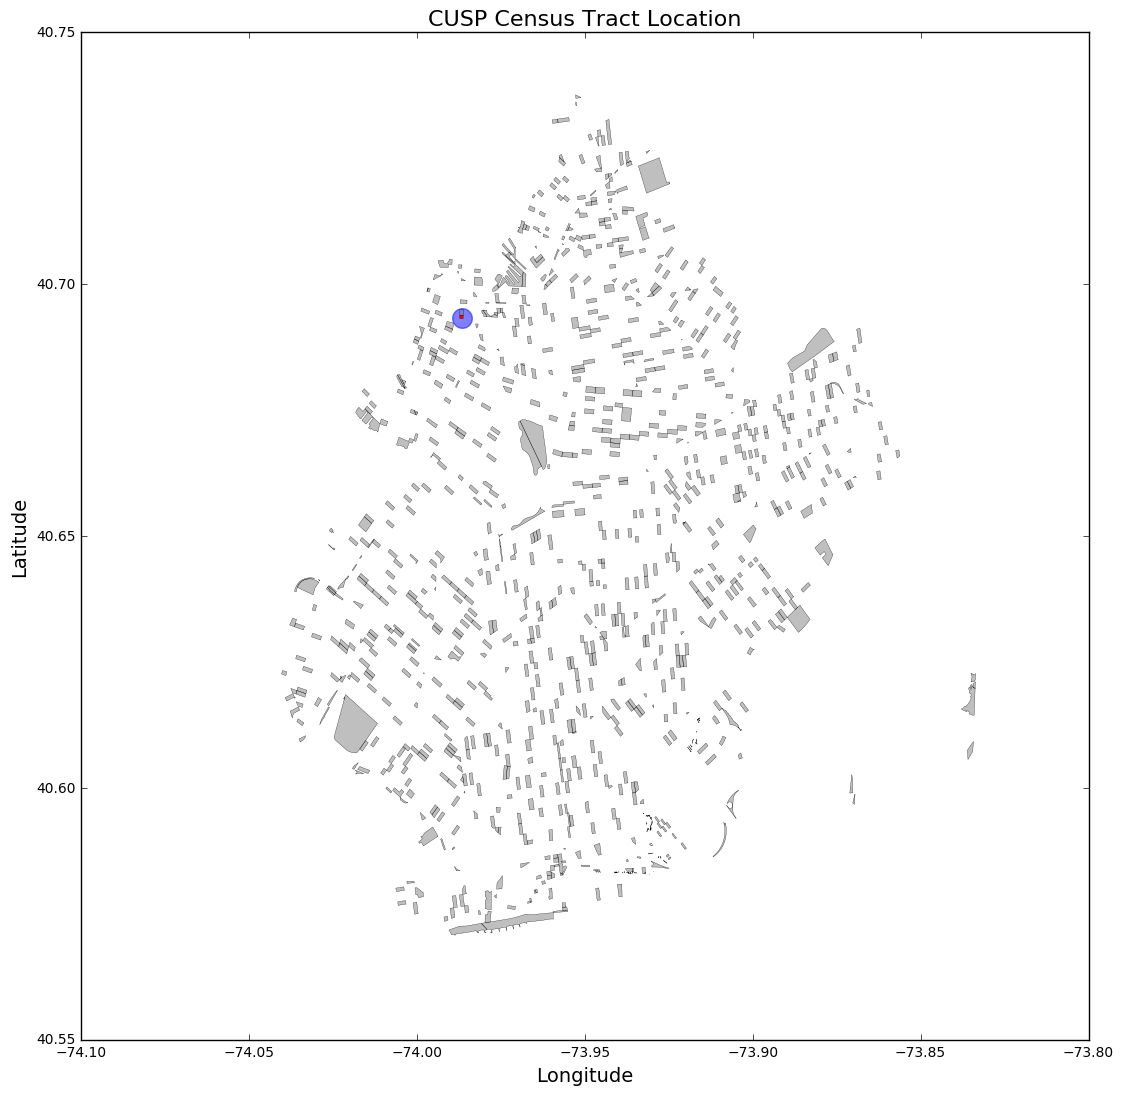

In [25]:
f, ax = plt.subplots(figsize=(13,13))

ctBK_latlng.iloc[::10, :].plot(color='grey', linewidth=0.2,ax=ax)
ax.scatter(CUSP_latlng[0], CUSP_latlng[1], color = 'blue', s=200, alpha = 0.5 )
CUSP_ct.plot(color='red', alpha=2, linewidth=0.2, ax=ax)

ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

pl.title('CUSP Census Tract Location', fontsize=16)
pl.show()

** FIGURE 01: Location of the Census Tract that contains CUSP plotted together with the other Census Tracts in Brooklyn (1 in every 10). **